# **TSLA Stock XGBoost Model**

In [1]:
!pip install shap

     -------------------------------------- 462.3/462.3 kB 2.4 MB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import shap
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [3]:
TSLA = pd.read_csv('TSLA_Final.csv')

In [4]:
X = TSLA.drop(['Adj Close', 'Close', 'Date'], axis=1)  # Features
y = TSLA['Adj Close']  # Target variable

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [6]:
base_model = xgb.XGBRegressor()

In [7]:
base_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [8]:
y_pred = base_model.predict(X_test)
df_pred = pd.DataFrame(y_pred, columns=['Predicted'])
df_pred

,Predicted
0,61.834496
1,224.427734
2,135.220535
3,262.117554
4,186.735764
...,...
472,20.322720
473,16.510757
474,20.515602
475,239.014664


In [9]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 11.09091704203654


In [10]:
import numpy as np

# Get feature importances from the trained model
feature_importances = base_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances * 100})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
1,High,85.906433
2,Low,9.545792
10,SMA_20,4.000798
0,Open,0.425941
12,EMA_12,0.044216
8,Yest_Close,0.015778
13,EMA_26,0.013158
9,stock_return,0.012032
11,SMA_50,0.009231
15,RSI,0.007279


In [11]:
# Select the top k significant features
k = 10  # Number of significant features to select
significant_features = feature_importance_df.head(k)['Feature'].values

# Filter the data to keep only the significant features
X_significant_training = X_train[significant_features]
X_significant_testing = X_test[significant_features]

In [12]:
# Retrain the model using only the significant features
model_retrained = xgb.XGBRegressor()
model_retrained.fit(X_significant_training, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [13]:
y_pred_retrained = model_retrained.predict(X_significant_testing)
df_pred_retrained = pd.DataFrame(y_pred_retrained, columns=['Optimized Predicted'])
df_pred_retrained

,Optimized Predicted
0,60.660419
1,228.354324
2,135.641678
3,261.355133
4,184.304321
...,...
472,20.177444
473,16.283981
474,21.136560
475,241.805893


In [14]:
mse = mean_squared_error(y_test, y_pred_retrained)
print("Mean Squared Error:", mse)

Mean Squared Error: 9.071567303904702


In [15]:
df_test = pd.DataFrame(y_test, columns=['Adj Close'])
df_test.reset_index(drop=True, inplace=True)
df_test

,Adj Close
0,62.711334
1,223.656662
2,139.043335
3,264.510010
4,190.720001
...,...
472,20.368000
473,16.319332
474,20.674667
475,245.529999


In [16]:
# Concatenate the dataframes horizontally
merged_df = pd.concat([df_test, df_pred, df_pred_retrained], axis=1)
merged_df

,Adj Close,Predicted,Optimized Predicted
0,62.711334,61.834496,60.660419
1,223.656662,224.427734,228.354324
2,139.043335,135.220535,135.641678
3,264.510010,262.117554,261.355133
4,190.720001,186.735764,184.304321
...,...,...,...
472,20.368000,20.322720,20.177444
473,16.319332,16.510757,16.283981
474,20.674667,20.515602,21.136560
475,245.529999,239.014664,241.805893


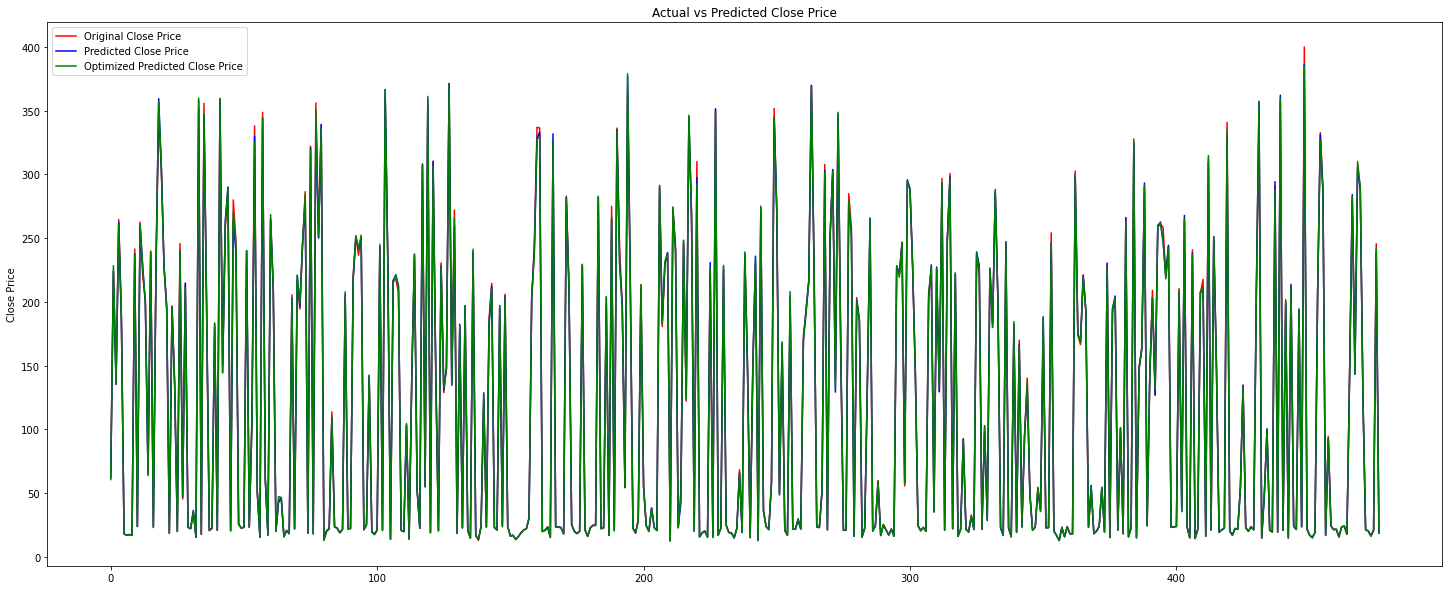

In [17]:
# Plot the line chart
plt.figure(figsize=(25, 10))

plt.plot(merged_df['Adj Close'], color= 'red', label='Original Close Price',)
plt.plot(merged_df['Predicted'], color='blue', label='Predicted Close Price')
plt.plot(merged_df['Optimized Predicted'], color='green', label='Optimized Predicted Close Price')

# Set the labels and title
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

## **Sharp Analysis**

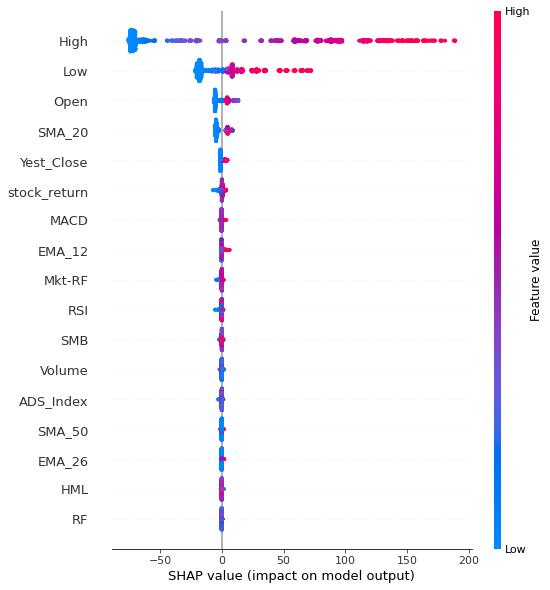

In [18]:
# Create an explainer object
explainer = shap.Explainer(base_model, X)
# Calculate SHAP values
shap_values = explainer.shap_values(X)
# Plot summary plot
shap.summary_plot(shap_values, X)

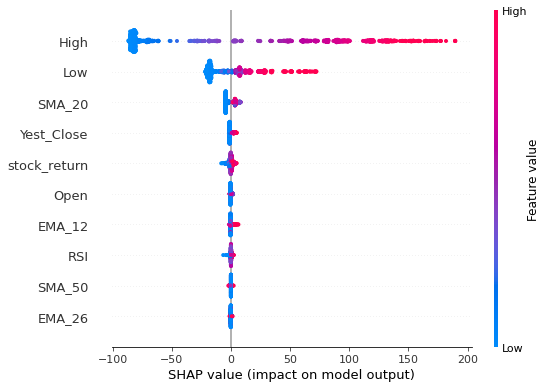

In [19]:
# Create an explainer object
explainer_retrained = shap.Explainer(model_retrained, X_significant_training)
# Calculate SHAP values
shap_values_retrained = explainer_retrained.shap_values(X_significant_training)
# Plot summary plot
shap.summary_plot(shap_values_retrained, X_significant_training)